In [1]:
from util import load_assignments, load_features, load_text

all_topics = list(load_features("data/output/humor_crowd/refinement.gpt-4.1.md").keys())

## How do BL sentences with different labels differ?

In [2]:
import pandas as pd

texts = load_text("data/input/bulwer.jsonl")
bl_assignments = load_assignments("data/output/humor_crowd/assignment_bulwer.gpt-4.1.jsonl")
bl_full = pd.read_csv("../data/Bulwer-Lytton.tsv", encoding="utf-8", quoting=3, sep="\t").set_index("sentence").sort_index()

In [3]:
bl_assignments["category"] = bl_assignments["id"].apply(lambda instance_id: bl_full.loc[texts[instance_id]]["category"])

In [4]:
category_counts = bl_assignments.value_counts("category")
keep_categories = set(category_counts[category_counts >= 50].index)

In [5]:
import re

category_breakdown = bl_assignments[bl_assignments["category"].isin(keep_categories)].groupby("category")[all_topics].mean()
category_breakdown.index = ["Dishonorable Mentions" if "Misc" in category else category for category in category_breakdown.index]
category_breakdown.index = [re.sub(r"(.+)\s(\w+)$", r"\1\n\2", category) for category in category_breakdown.index]

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

def create_heatmap(data, output_file=None, figsize=None, **kwargs):
    if figsize:
        plt.figure(figsize=figsize)
    sns.heatmap(data, cmap="Blues", vmin=0, vmax=1, square=False, **kwargs)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    if output_file:
        plt.tight_layout()
        plt.savefig(output_file)
    else:
        plt.show()

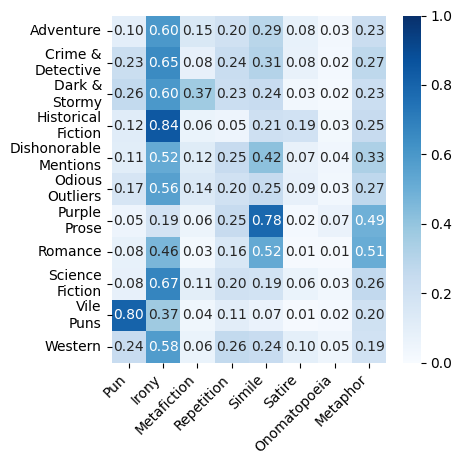

In [7]:
create_heatmap(category_breakdown, annot=True, fmt=".2f", output_file="topic_category.pdf", figsize=(4.75, 4.75))

How do BL Sentences Differ from Baselines?

In [8]:
def compute_topic_presence_by_dataset(topics_path, dataset_assignments):
    all_topics = list(load_features(topics_path).keys())
    assignments_by_dataset = {}
    for dataset, assignments_path in dataset_assignments:
        assignments_by_dataset[dataset] = load_assignments(assignments_path)
    assignments_by_dataset_avg = {k: v[all_topics].mean() for k, v in assignments_by_dataset.items()}
    return pd.DataFrame(assignments_by_dataset_avg).T

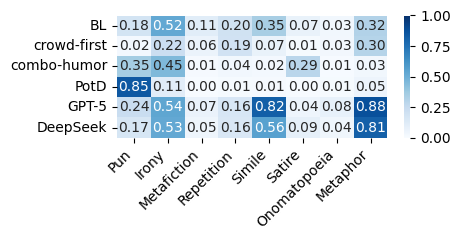

In [9]:
assignments_by_dataset = compute_topic_presence_by_dataset("data/output/humor_crowd/refinement.gpt-4.1.md",
                                               [("BL", "data/output/humor_crowd/assignment_bulwer.gpt-4.1.jsonl"),
                                                ("crowd-first", "data/output/humor_crowd/assignment_crowd.gpt-4.1.jsonl"),
                                                ("combo-humor", "data/output/humor_crowd/assignment_combo.gpt-4.1.jsonl"),
                                                ("PotD", "data/output/humor_crowd/assignment_PotD.gpt-4.1.jsonl"),
                                                ("GPT-5", "data/output/humor_crowd/assignment_gen_gpt5.gpt-4.1.jsonl"),
                                                ("DeepSeek", "data/output/humor_crowd/assignment_gen_deepseek.gpt-4.1.jsonl")])

create_heatmap(assignments_by_dataset, annot=True, fmt=".2f", figsize=(4.75, 2.5), output_file="topic_main.pdf")

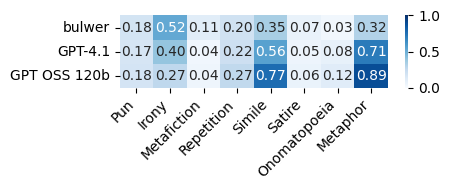

In [10]:
assignments_by_dataset = compute_topic_presence_by_dataset("data/output/humor_crowd/refinement.gpt-4.1.md",
                                               [("bulwer", "data/output/humor_crowd/assignment_bulwer.gpt-4.1.jsonl"),
                                                ("GPT-4.1", "data/output/humor_crowd/assignment_gen_gpt41.gpt-4.1.jsonl"),
                                                # ("GPT-5", "data/output/humor_crowd/assignment_gen_gpt5.gpt-4.1.jsonl"),
                                                # ("DeepSeek", "data/output/humor_crowd/assignment_gen_deepseek.gpt-4.1.jsonl"),
                                                ("GPT OSS 120b", "data/output/humor_crowd/assignment_gen_gpt120b.gpt-4.1.jsonl")])

create_heatmap(assignments_by_dataset, annot=True, figsize=(4.75, 2), fmt=".2f", output_file="topic_synthetic_other.pdf")